# Keras tutorial

The goal of this tutorial is to very quickly present keras, the high-level API of tensorflow, as it has already been seen in the Neurocomputing exercises. We will train a small fully-connected network on MNIST and observe what happens when the inputs or outputs are correlated, by training successively on the 0 digits, then the 1, etc. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Keras

The first step is to install tensorflow. The easiest way is to use pip:
    
```bash
pip install tensorflow
```

`keras` is now available as a submodule of tensorflow (you can also install it as a separate package):

```python
import tensorflow as tf
```

Keras provides a lot of ready-made layer types, activation functions, optimizers and so on. Do not hesitate to read its documentation on <https://keras.io>.

In [2]:
import tensorflow as tf

The most important object in keras is `Sequential`. It is a container where you sequentially add layers of neurons (fully-connected, convolutional, recurrent, etc) and other stuff. It represents your model, i.e. the neural network itself.

```python
model = tf.keras.models.Sequential()
```

You can then `add()` layers to the model. A fully-connected layer is called `Dense` in keras. 

Let's create a MLP with 10 input neurons, two hidden layers with 100 hidden neurons each and 3 output neurons. 

The input layer is represented by the `Input` layer:

```python
model.add(tf.keras.layers.Input((10,)))
```

The first hidden layer can be added to the model with:

```python
model.add(tf.keras.layers.Dense(100, activation="relu"))
```

The layer has 100 neurons and uses the ReLU activation function. One could optionally define the activation function as an additional "layer", but it is usually not needed:

```python
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Activation('relu'))
```

Adding more layers is straightforward:

```python
model.add(tf.keras.layers.Dense(100, activation="relu"))
```

Finally, we can add the output layer. The activation function depends on the problem:

* For regression problems, a linear activation function should be used when the targets can take any value (e.g. Q-values):

```python
model.add(tf.keras.layers.Dense(3, activation="linear"))
```

If the targets are bounded between 0 and 1, a logistic/sigmoid function can be used:

```python
model.add(tf.keras.layers.Dense(3, activation="sigmoid"))
```

* For multi-class classification problems, a softmax activation function should be used:

```python
model.add(tf.keras.layers.Dense(3, activation="softmax"))
```

This defines fully the structure of your desired neural network.

**Q:** Implement a neural network for classification with 10 input neurons, two hidden layers with 100 neurons each (using ReLU) and 3 output neurons.

*Hint:* `print(model.summary())` gives you a summary of the architecture of your model. Note in particular the number of trainable parameters (weights and biases).

In [3]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((10,)))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
print(model.summary())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1100      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 11,503
Trainable params: 11,503
Non-trainable params: 0
_________________________________________________________________
None


2022-11-24 18:31:35.132826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 18:31:35.133149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The next step is to choose an **optimizer** for the neural network, i.e. a variant of gradient descent that will be used to iteratively modify the parameters.

`keras` provides an extensive list of optimizers: <https://keras.io/optimizers/>. The most useful in practice are:

* `SGD`, the vanilla stochastic gradient descent.

```python
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
```

* `RMSprop`, using second moments:

```python
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
```

* `Adam`:

```python
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
```

Choosing a optimizer is a matter of taste and trial-and-error. In deep RL, a good choice is Adam: the default values for its other parameters are usually good, it converges well, so your only job is to find the right learning rate.

Finally, the model must be **compiled** by defining:

* A loss function. For multi-class classification, it should be `'categorical_crossentropy'`. For regression, it can be `'mse'`. See the list of built-in loss functions here: <https://keras.io/losses/> but know that you can also simply define your own.

* The chosen optimizer.

* The metrics, i.e. what you want tensorflow to print during training. By default it only prints the current value of the loss function. For classification tasks, it usually makes more sense to also print the `accuracy`.

```python
model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
)
```

**Q:** Compile the model for classification, using the Adam optimizer and a learning rate of 0.01.

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer,
    metrics=['accuracy']
)

Let's now train the model on some dummy data. To show the power of deep neural networks, we will try to learn noise by heart.

The following cell creates an input tensor `X` with 1000 random vectors of 10 elements, with values sampled between -1 and 1. The targets (desired outputs) `t` are class indices (0, 1 or 2), also randomly selected.  

However, neural networks expect **one-hot encoded vectors** for the target, i.e. (1, 0, 0), (0, 1, 0), (0, 0, 1) instead of 0, 1, 2. The method `tf.keras.utils.to_categorical` allows you to do that.

In [5]:
X = np.random.uniform(-1.0, 1.0, (1000, 10))
t = np.random.randint(0, 3, (1000, ))
T = tf.keras.utils.to_categorical(t, 3)

Let's learn it. The `Sequential` model has a method called `fit()` where you simply pass the training data `(X, T)` and some other parameters, such as:

* the batch size,
* the total number of epochs,
* the proportion of training examples to keep in order to compute the validation loss/accuracy (optional but recommmended).

```python
# Training
history = tf.keras.callbacks.History()

model.fit(
    X, T,
    batch_size=100, 
    epochs=50,
    validation_split=0.1,
    callbacks=[history]
)
```

**Q:** Train the model on the data, using a batch size of 100 for 50 epochs. Explain why you obtained this result.

In [6]:
history = model.fit(
    X, T,
    batch_size=100, 
    epochs=50,
    validation_split=0.1,
    verbose=2
)

Epoch 1/50


2022-11-24 18:31:37.930309: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-24 18:31:38.157447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 - 1s - loss: 1.1183 - accuracy: 0.3244 - val_loss: 1.1404 - val_accuracy: 0.3300 - 1s/epoch - 162ms/step
Epoch 2/50
9/9 - 0s - loss: 1.0802 - accuracy: 0.3878 - val_loss: 1.1295 - val_accuracy: 0.2700 - 96ms/epoch - 11ms/step
Epoch 3/50


2022-11-24 18:31:39.375487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 - 0s - loss: 1.0632 - accuracy: 0.4667 - val_loss: 1.1320 - val_accuracy: 0.2500 - 93ms/epoch - 10ms/step
Epoch 4/50
9/9 - 0s - loss: 1.0375 - accuracy: 0.4767 - val_loss: 1.1671 - val_accuracy: 0.2500 - 89ms/epoch - 10ms/step
Epoch 5/50
9/9 - 0s - loss: 1.0111 - accuracy: 0.5111 - val_loss: 1.1752 - val_accuracy: 0.3100 - 89ms/epoch - 10ms/step
Epoch 6/50
9/9 - 0s - loss: 0.9863 - accuracy: 0.5033 - val_loss: 1.2184 - val_accuracy: 0.2800 - 90ms/epoch - 10ms/step
Epoch 7/50
9/9 - 0s - loss: 0.9553 - accuracy: 0.5433 - val_loss: 1.2167 - val_accuracy: 0.2800 - 89ms/epoch - 10ms/step
Epoch 8/50
9/9 - 0s - loss: 0.9197 - accuracy: 0.5678 - val_loss: 1.3535 - val_accuracy: 0.3000 - 90ms/epoch - 10ms/step
Epoch 9/50
9/9 - 0s - loss: 0.8824 - accuracy: 0.5900 - val_loss: 1.3571 - val_accuracy: 0.3200 - 88ms/epoch - 10ms/step
Epoch 10/50
9/9 - 0s - loss: 0.8560 - accuracy: 0.6267 - val_loss: 1.3682 - val_accuracy: 0.2400 - 90ms/epoch - 10ms/step
Epoch 11/50
9/9 - 0s - loss: 0.8125 - accu

**A:** The final training is 100%, the validation accuracy is 33% (may vary depending on initialization). The network has learned the training examples by heart, although they are totally random, but totally fails to generalize.

The main is reason is that we have only 1000 training examples, with a total number of free parameters (VC dimension) around 11500. By definition, the model can learn this training set perfectly, although it is totally random. Its VC dimension is however way to high to generalize anything. It is even worse here: as the data is random, there is nothing to generalize. A nice example to understand why NN overfit...

## Training a MLP on MNIST

Let's now try to learn something a bit more serious, the MNIST dataset. The following cell load the MNIST data (training set 60000 28x28 monochrome images, test set of 10000 images), normalizes it (values betwen 0 and 1 for each pixel), removes the mean image from the training set and transforms the targets to one-hot encoded vectors for the 10 classes. See the neurocomputing exercise for more details.

In [7]:
# Load the MNIST dataset
(X_train, t_train), (X_test, t_test) = tf.keras.datasets.mnist.load_data()
print("Training data:", X_train.shape, t_train.shape)
print("Test data:", X_test.shape, t_test.shape)

# Reshape the images to vectors and normalize
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255.
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255.

# Mean removal
X_mean = np.mean(X_train, axis=0)
X_train -= X_mean
X_test -= X_mean

# One-hot encoded outputs
T_train = tf.keras.utils.to_categorical(t_train, 10)
T_test = tf.keras.utils.to_categorical(t_test, 10)

Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


**Q:** Create a fully connected neural network with 784 input neurons (one per pixel), 10 softmax output neurons and whatever you want in the middle, so that it can reach around 98% validation accuracy after **20 epochs**.

* Put the network creation (including `compile()`) in a method `create_model()`, so that you can create a model multiple times.
* Choose a good value for the learning rate.
* Do not exagerate with the number of layers and neurons. Two or there hidden layers with 100 to 300 neurons are more than enough.
* You will quickly observe that the network overfits: the training accuracy is higher than the validation accuracy. The training accuracy actually goes to 100% if your network is too big. In that case, feel free to add a dropout layer after each fully-connected layer:

```python
model.add(tf.keras.layers.Dropout(0.5))
```

In [8]:
def create_model():
    # Create the model
    model = tf.keras.models.Sequential()
    
    # Input layer with 784 pixels
    model.add(tf.keras.layers.Input((784,)))

    # Hidden layer with 150 neurons
    model.add(tf.keras.layers.Dense(150, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))

    # Second hidden layer with 100 neurons
    model.add(tf.keras.layers.Dense(100, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))

    # Softmax output layer with 10 neurons
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    # Learning rule
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Loss function
    model.compile(
        loss='categorical_crossentropy', # loss
        optimizer=optimizer, # learning rule
        metrics=['accuracy'] # show accuracy
    )
    print(model.summary())
    
    return model

In [9]:
model = create_model()

# Training
history = tf.keras.callbacks.History()

model.fit(
    X_train, T_train,
    batch_size=100, 
    epochs=20,
    validation_split=0.1,
    callbacks=[history]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 150)               117750    
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 133,860
Trainable params: 133,860
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20


2022-11-24 18:31:53.203907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


538/540 [============================>.] - ETA: 0s - loss: 0.5194 - accuracy: 0.8409

2022-11-24 18:31:58.951897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


540/540 [==============================] - 6s 11ms/step - loss: 0.5185 - accuracy: 0.8411 - val_loss: 0.1482 - val_accuracy: 0.9577
Epoch 2/20
540/540 [==============================] - 6s 10ms/step - loss: 0.2497 - accuracy: 0.9261 - val_loss: 0.1195 - val_accuracy: 0.9637
Epoch 3/20
540/540 [==============================] - 5s 10ms/step - loss: 0.2007 - accuracy: 0.9414 - val_loss: 0.0993 - val_accuracy: 0.9705
Epoch 4/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1732 - accuracy: 0.9485 - val_loss: 0.0932 - val_accuracy: 0.9718
Epoch 5/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1580 - accuracy: 0.9530 - val_loss: 0.0823 - val_accuracy: 0.9747
Epoch 6/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1453 - accuracy: 0.9562 - val_loss: 0.0819 - val_accuracy: 0.9752
Epoch 7/20
540/540 [==============================] - 5s 10ms/step - loss: 0.1319 - accuracy: 0.9602 - val_loss: 0.0800 - val_accuracy: 0.9747
Epoch 8/20

After training, one should evaluate the model on the test set. `keras` provides an `evaluate()` method that computes the different metrics (in our case the loss) on the data:

```python
score = model.evaluate(X_test, T_test)
```

Another solution would be to `predict()` labels on the test set and manually compare them to the ground truth:

```python
Y = model.predict(X_test)
loss = - np.mean(T_test * np.log(Y))
predicted_classes = np.argmax(Y, axis=1)
accuracy = 1.0 - np.sum(predicted_classes != t_test)/t_test.shape[0]
```

Another important thing to visualize after training is how the training and validation loss (or accuracy) evolved during training. The `fit()` method updates a `History` object which contains the history of your metrics (loss and accuracy) after each epoch of training. These are simple numpy arrays, accessible with:

```python
history.history['loss']
history.history['val_loss']
history.history['accuracy']
history.history['val_accuracy']
```

**Q:** Compute the test loss and accuracy of your model. Plot the history of the training and validation loss/accuracy.

 14/313 [>.............................] - ETA: 2s - loss: 0.0518 - accuracy: 0.9866

2022-11-24 18:33:42.354208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step - loss: 0.0763 - accuracy: 0.9782
Test loss: 0.07633379101753235
Test accuracy: 0.9782000184059143


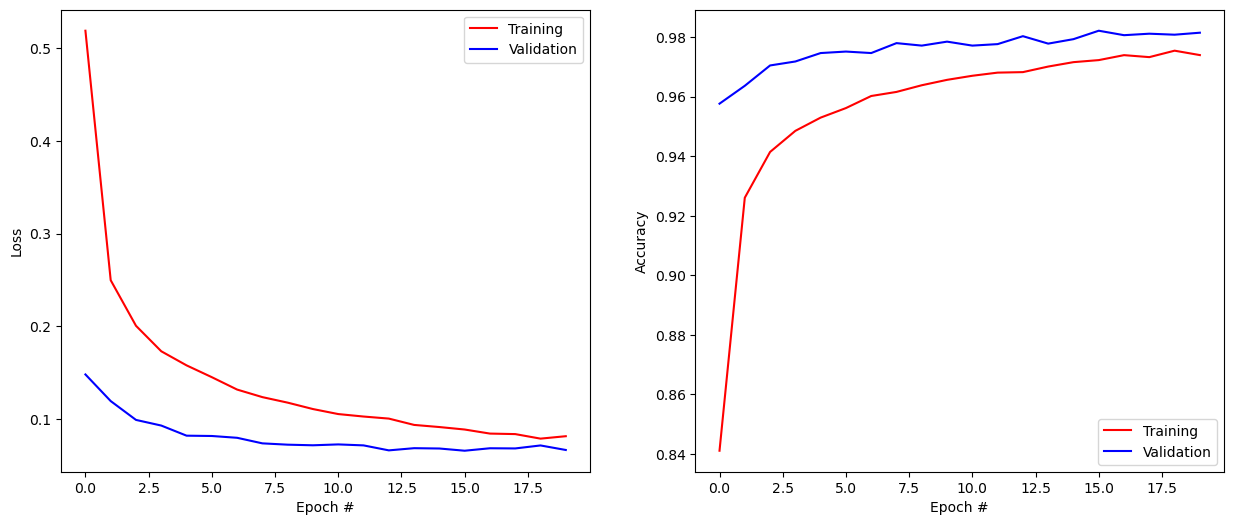

In [10]:
# Testing
score = model.evaluate(X_test, T_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Correlated inputs

Now that we have a basic NN working on MNIST, let's investigate why deep NN hate sequentially correlated inputs (which is the main justification for the experience replay memory in DQN). Is that really true, or is just some mathematical assumption that does not matter in practice?

The idea of this part is the following: we will train the same network as before for 20 epochs, but each epoch will train the network on all the 0s first, then all the 1s, etc. Each epoch will contain the same number of training examples as before, but the order of presentation will simply be different.

To get all examples of the training set which have the target 3 (for example), you just have to slice the matrices accordingly:

```python
X = X_train[t_train==3, :]
T = T_train[t_train==3]
```

**Q:** Train the same network as before (but reinitialize it!) for 20 epochs, with each epoch sequentially iterating over the classes 0, 1, 2, 3, etc. Plot the loss and accurary during training. What do you observe?

*Hint:* you will have two for loops to write: one over the epochs, one over the digits.

```python
for e in range(20):
    for c in range(10):
        model.fit(...)
```

You should only do one epoch for each call to `fit()`. Set `verbose=0` in `fit()` to avoid printing too much info.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 150)               117750    
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               15100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
Total params: 133,860
Trainable params: 133,860
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1


2022-11-24 18:33:52.698762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 18:33:53.547791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 Training loss: 2.1789441108703613
 Training accuracy: 0.4577885866165161
 Validation loss: 0.06307889521121979
 Validation accuracy: 0.9831932783126831
Epoch:  2
 Training loss: 1.1442071199417114
 Training accuracy: 0.7080687284469604
 Validation loss: 0.027842853218317032
 Validation accuracy: 0.9899159669876099
Epoch:  3
 Training loss: 0.8554081320762634
 Training accuracy: 0.7674636244773865
 Validation loss: 0.06736434251070023
 Validation accuracy: 0.9831932783126831
Epoch:  4
 Training loss: 0.6917049288749695
 Training accuracy: 0.7822189331054688
 Validation loss: 0.052796363830566406
 Validation accuracy: 0.9865546226501465
Epoch:  5
 Training loss: 0.5919428467750549
 Training accuracy: 0.8147180080413818
 Validation loss: 0.04681151360273361
 Validation accuracy: 0.9831932783126831
Epoch:  6
 Training loss: 0.4891780614852905
 Training accuracy: 0.8408666849136353
 Validation loss: 0.043771397322416306
 Validation accuracy: 0.9882352948188782
Epoch:  7
 Training loss: 0.4

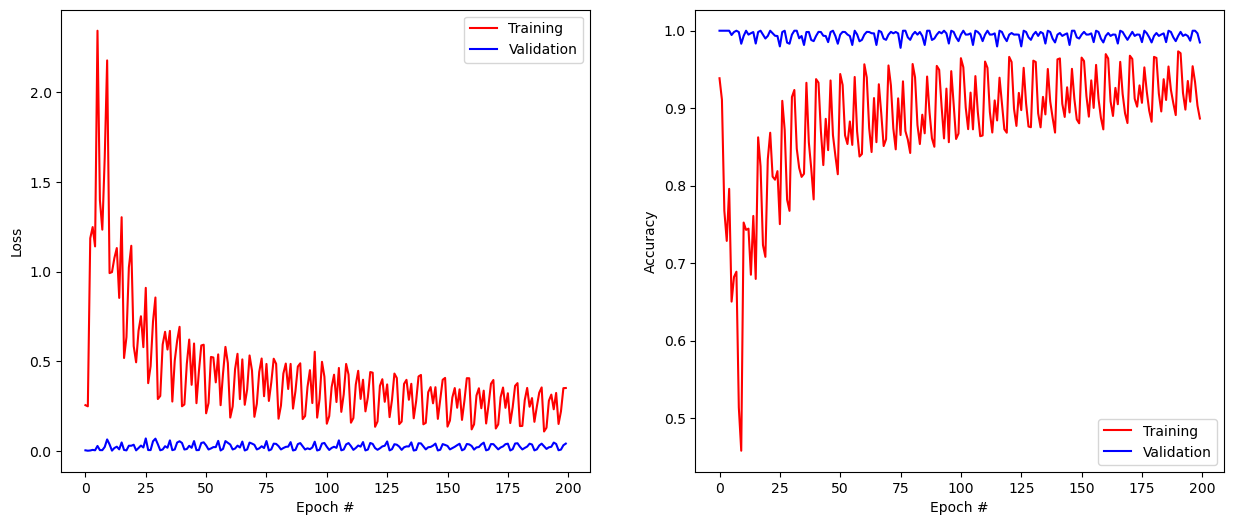

In [11]:
model = create_model()

history = tf.keras.callbacks.History()

for e in range(20):
    print("Epoch: ", e+1)
    for c in range(10):
        # Training
        model.fit(
            X_train[t_train==c, :], T_train[t_train==c, :],
            batch_size=100, 
            epochs=1,
            validation_split=0.1,
            verbose = 0,
            callbacks=[history]
        )
    print(" Training loss:", history.history["loss"][-1])
    print(" Training accuracy:", history.history["accuracy"][-1])
    print(" Validation loss:", history.history["val_loss"][-1])
    print(" Validation accuracy:", history.history["val_accuracy"][-1])
        
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(history.history['loss'], '-r', label="Training")
plt.plot(history.history['val_loss'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], '-r', label="Training")
plt.plot(history.history['val_accuracy'], '-b', label="Validation")
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**A:** The training accuracy slowly increases (with some oscillations, some numbers are harder to learn than others), but the validation accuracy is suspiciously high right from the start...

**Q:** Evaluate the model after training on the whole test set. What happens?

In [12]:
# Testing
score = model.evaluate(X_test, T_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7852121591567993
Test accuracy: 0.778700053691864


**A:** Horror! The test accuracy is now awful, although the training and validation accuracies were fine after 20 epochs.

**Q:** To better understand what happened, compute the test accuracy of the network on each class of the test set individually: all the 0s of the test set, then all the 1s, etc. What happens? 

In [13]:
for c in range(10):
    score = model.evaluate(X_test[t_test==c, :], T_test[t_test==c, :], verbose=0)
    print("Class", c)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Class 0
Test loss: 0.41480857133865356
Test accuracy: 0.9061225056648254
Class 1
Test loss: 0.5983759164810181
Test accuracy: 0.882819414138794
Class 2
Test loss: 0.9812650084495544
Test accuracy: 0.7490310072898865
Class 3
Test loss: 1.302044153213501
Test accuracy: 0.5524752736091614
Class 4
Test loss: 1.409988284111023
Test accuracy: 0.5346232652664185
Class 5
Test loss: 1.21005380153656
Test accuracy: 0.6838565468788147
Class 6
Test loss: 0.16447730362415314
Test accuracy: 0.9530271887779236
Class 7
Test loss: 1.548042893409729
Test accuracy: 0.5661478638648987
Class 8
Test loss: 0.17124219238758087
Test accuracy: 0.9691992402076721
Class 9
Test loss: 0.05847443267703056
Test accuracy: 0.9831516742706299


**A:** The last digits to be seen during training are the 9s: they have a good test accuracy. The 8s were seen not too long ago, they are also OK. But the other digits have been forgotten! The memory has been erased. This explains why you cannot train a deep network on-policy: the last episode would be remembered, but all the previous ones would be erased (catastrophic forgetting).

A notable exception is for the 6s, which look like 9s, and the 0s, which look like 8s: they share features with the digits which are well recognized, so they perform OK.

**Q:** Increase and decrease the learning rate of the optimizer. What do you observe? Is there a solution to this problem? 

**A:** Increasing the learning rate worsens the problem. Decreasing does help, but then learning is very slow. This is classical example of catastrophic forgetting: learning a new task erases the previous ones. There is no solution to this problem for now, apart from taking **i.i.d** samples in each minibatch.